## Understanding Airbnb Datasets

This notebook is dealing with the Aribnb datasets in Seattle and Boston and trying to provide more insights for 
business owners on market prices and how to improve customer experiences. 

There're three business questions to be answered:
1) Which indexes affect the price most, and how?
2) What's the difference of Airbnb markets between Seattle and Boston?
3) Which aspects are valued most in terms of customer experience?


### Dataset preview

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error


import seaborn as sns
%matplotlib inline

df_lst_seattle = pd.read_csv('./listings_seattle.csv')
df_lst_seattle.head()



,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


### Question 1: Which indexes affect the price most, and how?

In this question we're looking at column: 'price' and trying to implement linear model on some chosen indexes that 
might take effect in it. 

Potential variables that affect price:

1. 'neighborhood_cleansed'
2. 'accommodates'
3. 'property_type'
4. 'room_type'
5. 'bedrooms'


To better analyse the data, we need to look at data types of each columns and preclean the data by converting fromat 
and imputing Nan values.


In [4]:
df_lst_seattle['price'].head()


0     $85.00
1    $150.00
2    $975.00
3    $100.00
4    $450.00
Name: price, dtype: object

#### Precleaning the data

Here we first convert the formatting and data type of 'price' column, and then preclean the dataframe as tutorials. 

For numerical variables like 'accommodates' and 'bedrooms', NaN value is imputed by the mean. Simply dropping the entire row will remove information that may be useful for our prediction. Because there's no abnormal high valuee, mean value can be the best one to be imputed. 

For categorical variables like 'neighbourhood_cleansed', 'property_type' and 'room_type', we encode them into dummies by removing original columns with data type of 'object' and concatenate dummy columns into the dataframe. This dummy columns can help us demonstrate which category in which variable more contributes to the target variable. For example, 'entire room' of 'room_type' may indicate a higher price.


In [12]:
df_lst_seattle['price'].replace('[\$,]', '', regex=True, inplace=True)
df_lst_seattle['price'] = df_lst_seattle['price'].astype(float)

def preclean(df):
    
    
    df['price'].replace('[\$,]', '', regex=True, inplace=True)
    df['price'] = df['price'].astype(float)
    
    df = df.dropna(subset=['price'], axis=0)
    
    y = df['price']
    
    X = df[['neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates', 'bedrooms']]
    
    num_vars = X.select_dtypes(include=['int', 'float']).columns
    
    for col in num_vars:
        X[col].fillna((X[col].mean()), inplace=True)
    
    cat_vars = X.select_dtypes(include=['object']).columns
    
    for var in cat_vars:
        X = pd.concat([X.drop([var], axis=1), pd.get_dummies(X[var], drop_first=True)], axis=1)
    
    return X, y

Here shows the dataframe after precleaning.

In [13]:
X_sea, y_sea = preclean(df_lst_seattle)

X_sea.head()

c:\users\my pc\anaconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,accommodates,bedrooms,Alki,Arbor Heights,Atlantic,Belltown,Bitter Lake,Briarcliff,Brighton,Broadview,...,Dorm,House,Loft,Other,Tent,Townhouse,Treehouse,Yurt,Private room,Shared room
0,4,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11,5.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,3,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,3.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


#### Building model

Here we split datasets and apply linear model to fit the data.

In [14]:
#Split into train and test
X_sea_train, X_sea_test, y_sea_train, y_sea_test = train_test_split(X_sea, y_sea, test_size = .30, random_state=42) 

lm_model_sea = LinearRegression(normalize=True) # Instantiate
lm_model_sea.fit(X_sea_train, y_sea_train) #Fit
        
#Predict and score the model
y_sea_test_preds = lm_model_sea.predict(X_sea_test) 
"The r-squared score for your model was {} on {} values.".format(r2_score(y_sea_test, y_sea_test_preds), len(y_sea_test))

'The r-squared score for your model was 0.5751219375445931 on 1146 values.'

Using the following function, we can see which indexes affects the price most.

In [15]:
def coef_weights(coefficients, X_train):

   
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = coefficients
    coefs_df['abs_coefs'] = np.abs(coefficients)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_sea_df = coef_weights(lm_model_sea.coef_, X_sea_train)

#A quick look at the top results
coef_sea_df.head(30)

,est_int,coefs,abs_coefs
89,Boat,167.048944,167.048944
95,Dorm,-137.715151,137.715151
62,Portage Bay,87.738386,87.738386
74,Southeast Magnolia,85.343317,85.343317
61,Pioneer Square,85.106157,85.106157
59,Pike-Market,83.409198,83.409198
33,Industrial District,78.724175,78.724175
84,Westlake,68.613684,68.613684
104,Shared room,-66.006801,66.006801
82,West Queen Anne,63.599529,63.599529


Following figure showes the top 10 area that most Airbnb businesses locate.

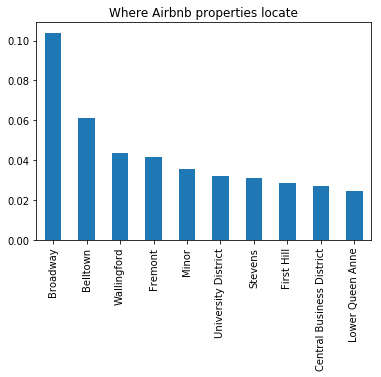

In [16]:
loc_vals = df_lst_seattle['neighbourhood_cleansed'].value_counts()

(loc_vals[0:10]/df_lst_seattle.shape[0]).plot(kind="bar");
plt.title("Where Airbnb properties locate");

#### Conclusions

In conlusion, the location of the Airbnb property plays the most important role in its pricing. Property in Portage Bay, Southeast Magnolia and Pioneer Square tends to have higher price than other locations. Some locations, like South Park, is not ideal locations for Airbnb business. 

Property type can also affect the price. Some rare property types like 'Boat' and 'Dorm' are top indicators of the pricing. Whereas the lack of data may leads to inappropriate judgements on how much the price indicated by property type. In terms of room type, sharing room usually indicates a low price. The number of bedrooms is also an indicator, but not crucial as location and room type.

In [17]:
df_lst_seattle['neighbourhood_cleansed'].value_counts()

Broadway                     397
Belltown                     234
Wallingford                  167
Fremont                      158
Minor                        135
University District          122
Stevens                      119
First Hill                   108
Central Business District    103
Lower Queen Anne              94
Greenwood                     89
East Queen Anne               82
North Beacon Hill             78
Phinney Ridge                 73
Adams                         70
Ravenna                       67
Mann                          67
West Queen Anne               65
West Woodland                 64
Columbia City                 58
Green Lake                    54
North Queen Anne              54
Leschi                        53
Atlantic                      53
Loyal Heights                 52
Mount Baker                   50
North Admiral                 49
Madrona                       47
Eastlake                      45
Seward Park                   44
          

### Question 2: What's the difference of Airbnb markets between Seattle and Boston?

In this question, we're looking into the difference of Airbnb markets between Seattle and Boston.

The average pricing and rating is compared to give a general idea on the differences. Moreoever, the pricing of the Boston is also analysed and compared with the conclusion we draw from Seattle Airbnb dataset.

#### Dataset preview

In [18]:
df_lst_boston = pd.read_csv('./listings_boston.csv')
df_lst_boston.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


#### Average price and rating

In [19]:
df_lst_boston['price'].replace('[\$,]', '', regex=True, inplace=True)
df_lst_boston['price'] = df_lst_boston['price'].astype(float)

price_boston = df_lst_boston['price'].mean()
price_seattle = df_lst_seattle['price'].mean()

"The average price of Airbnb is ${:.2f} in Boston, and ${:.2f} in Seattle, which is ${:.2f} {} than Boston".format(price_boston, price_seattle, abs(price_seattle-price_boston), 'higher' if price_seattle>price_boston else 'lower')

'The average price of Airbnb is $173.93 in Boston, and $127.98 in Seattle, which is $45.95 lower than Boston'

In [20]:
review_boston = df_lst_boston['review_scores_rating'].mean()
review_seattle = df_lst_seattle['review_scores_rating'].mean()   

"The average review rating of Airbnb is {:.2f} in Boston, and {:.2f} in Seattle.".format(review_boston, review_seattle)

'The average review rating of Airbnb is 91.92 in Boston, and 94.54 in Seattle.'

#### Building model

In [21]:
X_bos, y_bos = preclean(df_lst_boston)

#Split into train and test
X_bos_train, X_bos_test, y_bos_train, y_bos_test = train_test_split(X_bos, y_bos, test_size = .30, random_state=42) 

lm_model_bos = LinearRegression(normalize=True) # Instantiate
lm_model_bos.fit(X_bos_train, y_bos_train) #Fit
        
#Predict and score the model
y_bos_test_preds = lm_model_bos.predict(X_bos_test) 
"The r-squared score for your model was {} on {} values.".format(r2_score(y_bos_test, y_bos_test_preds), len(y_bos_test))

c:\users\my pc\anaconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


'The r-squared score for your model was 0.27556336739960574 on 1076 values.'

In [22]:
#Use the function
coef_bos_df = coef_weights(lm_model_bos.coef_, X_bos_train)

#A quick look at the top results
coef_bos_df.head(30)

,est_int,coefs,abs_coefs
22,South Boston Waterfront,152.336313,152.336313
28,Camper/RV,-149.265628,149.265628
14,Leather District,115.508247,115.508247
2,Back Bay,109.783901,109.783901
3,Bay Village,103.930813,103.930813
4,Beacon Hill,102.918218,102.918218
9,Downtown,92.902789,92.902789
11,Fenway,86.349016,86.349016
23,South End,73.188530,73.188530
39,Shared room,-72.663745,72.663745


#### Conclusions

In general, on one hand the average pricing in Boston is higher than Seattle, on the other, customers in Seattle are more satisfied with their experience than in Boston. For the price-indicating indexes, as in Seattle, location is also the top indicator. The room type and number of bedrooms plays more important roles, whereas the rare property types such as 'Boat' and 'Dorm' in Seattle are not shown in the list above, 'Camper/RV' instead. Therefore, these factors cannot be seen as a good indicator of its price.

In [23]:
df_lst_boston['property_type'].value_counts()

Apartment          2612
House               562
Condominium         231
Townhouse            54
Bed & Breakfast      41
Loft                 39
Other                17
Boat                 12
Villa                 6
Entire Floor          4
Dorm                  2
Camper/RV             1
Guesthouse            1
Name: property_type, dtype: int64

### Question 3: Which aspects are valued most in terms of customer experience?

As a Airbnb business owner, you're not only targeting to higher profits, but also improving customer experience. Good reputation make your business more popular. This question is trying to provide the owners which aspects should improve the most to get an overall better rating.

#### Dataset preview

In [24]:
df_lst_seattle[['review_scores_rating', 'review_scores_accuracy']].head()

,review_scores_rating,review_scores_accuracy
0,95.0,10.0
1,96.0,10.0
2,97.0,10.0
3,NaN,NaN
4,92.0,9.0


#### Preclean the data

In [25]:
def preclean_review(df):
        
    df = df.dropna(subset=['review_scores_rating'], axis=0)
    y = df['review_scores_rating'].astype(float)
    
    X = df[['review_scores_value', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location']].astype(float)
    
    num_vars = X.select_dtypes(include=['int', 'float']).columns
    
    for col in num_vars:
        X[col].fillna((X[col].mean()), inplace=True)
    
    cat_vars = X.select_dtypes(include=['object']).columns
    
    for var in cat_vars:
        X = pd.concat([X.drop([var], axis=1), pd.get_dummies(X[var], drop_first=True)], axis=1)
    
    return X, y

#### Building, training and predicting

In [26]:
X_rev, y_rev = preclean_review(df_lst_seattle)

#Split into train and test
X_rev_train, X_rev_test, y_rev_train, y_rev_test = train_test_split(X_rev, y_rev, test_size = .30, random_state=42) 

lm_model_rev = LinearRegression(normalize=True) # Instantiate
lm_model_rev.fit(X_rev_train, y_rev_train) #Fit
        
#Predict and score the model
y_rev_test_preds = lm_model_rev.predict(X_rev_test) 
"The r-squared score for your model was {} on {} values.".format(r2_score(y_rev_test, y_rev_test_preds), len(y_rev_test))

'The r-squared score for your model was 0.6485531047095812 on 952 values.'

#### Analysing key factors

In [27]:
#Use the function
coef_df_rev = coef_weights(lm_model_rev.coef_, X_rev_train)

#A quick look at the top results
coef_df_rev.head(30)

,est_int,coefs,abs_coefs
0,review_scores_value,3.058346,3.058346
2,review_scores_cleanliness,2.352576,2.352576
1,review_scores_accuracy,1.526999,1.526999
3,review_scores_checkin,1.294785,1.294785
4,review_scores_communication,1.267077,1.267077
5,review_scores_location,0.533938,0.533938


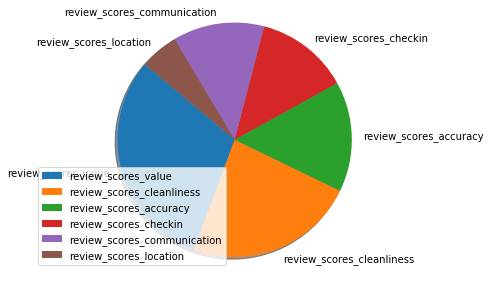

In [28]:
patches, texts = plt.pie(coef_df_rev['abs_coefs'], labels=coef_df_rev['est_int'], shadow=True, startangle=140)

plt.legend(patches, coef_df_rev['est_int'], loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

#### Conclusion

As shown in the list above, the value and cleanliness are the top two factors that the business owner should consider to improve their customer experience. In contrast to price prediction, location is the least factor that affects the customer experience.